## Train models

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt 
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pickle

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest_alt', default='trained_models/dgcca_toy_altmaxvar_test.model', help="Destination model path")
parser.add_argument('--model_dest_cute', default='trained_models/dgcca_toy_cutemaxvar_test.model', help="Destination model path")

parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=False, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=1000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=10, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=50, help='')
parser.add_argument('--n_trials', default=2, help='')


args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0

device = torch.device(args['device'])

acc = {'alt':np.zeros((args['n_trials'], args['num_epochs'])),
      'cute':np.zeros((args['n_trials'], args['num_epochs']))}

compress_exps = [True, False]

# acc_alt = np.zeros((args['n_trials'], args['num_epochs']))
# acc = pickle.load(open('../plt/acc_cute_toy.pkl', 'rb'))
for compress in compress_exps:
    args['compress'] = compress
    if compress:
        args['model_dest'] = args['model_dest_cute']
    else:
        args['model_dest'] = args['model_dest_alt']
    for trial_id in range(args['n_trials']):
        run_data = []

        # eval and train models and copy the train params to eval
        dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca_train = dgcca_train.to(device)
        dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca_eval.load_state_dict(dgcca_train.state_dict())

        # Get train and validation dataset
        train_views, train_classes = create_synthData(N=10000)
        val_views, val_classes = create_synthData(N=2000)
        # shuffle the dataset
        suffler = torch.randperm(10000)
        train_views = [view[suffler].to(device) for view in train_views]

        val_shuffler = torch.randperm(2000)
        val_views = [view[val_shuffler].to(device) for view in val_views]
        val_classes = [classes[val_shuffler] for classes in val_classes]

        optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
        num_batches = len(train_views[0])//args['batch_size']

        criterion = loss_func()
        num_val_batches = len(val_views[0])//args['batch_size']

        # init G
        dgcca_eval.eval()
        M_client = torch.stack(dgcca_eval(train_views))
        G_server = g_step(M_client.clone().detach())  

        M_serv = M_client.clone()
        G_client = G_server.clone()

        dgcca_train.train()

        for epoch in range(args['num_epochs']):
            total_dgcca_loss = 0
            total_val_loss = 0
            batch_count = 0

            for j in range(args['inner_epochs']):
                for i in range(num_batches):
                    optimizer.zero_grad()
                    batch = []

                    # SGD

                    batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
                    target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

                    # full gradient
                    # batch = train_views
                    # target = G

                    out = torch.stack(dgcca_train(batch))  

                    loss = 1/2*torch.norm(out-target)/target.shape[0]

                    loss.backward()
                    optimizer.step()

                    total_dgcca_loss += loss.item()

            ## Update G
            dgcca_eval.load_state_dict(dgcca_train.state_dict())
            M_client = dgcca_eval(train_views)
            M_client = torch.stack(M_client)

            if args['compress']:
                for i in range(len(train_views)):
                    diff = M_client[i] - M_serv[i]
                    max_val = diff.abs().max()
                    if args['compression_scheme'] == 'qsgd':
                        quant = qsgd(diff, n_bits=args['nbits'])
                    else:
                        quant = ((1/max_val)*diff).round()*(max_val/1)    
                    M_serv[i] = M_serv[i] + quant
                    M_serv[i] -= M_serv[i].mean(dim=0)
                    del max_val, diff, quant
                    G_serv = g_step(M_serv.clone().detach())

                if args['compress_downlink']:
                    if args['compression_scheme'] == 'qsgd':
                        G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
                    else:
                        # TODO: implement compression inside functions
                        G_client = G_serv.clone()
                else:
                    G_client = G_serv.clone()
            else:
                M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
                M_serv = M_client.clone()
                G_serv = g_step(M_serv.clone().detach())  
                G_client = G_serv.clone() 
            del M_client

            # validation loss
            out_val = torch.stack(dgcca_eval(val_views))
            G_val = g_step(out_val.clone().detach())
            loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
            total_val_loss = loss_val.item()

            clf = svm.LinearSVC()
            clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

            results = OrderedDict()
            results['epoch'] = epoch
            results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
            results['val_fidelity'] = total_val_loss
            results['batch_size'] = args['batch_size']
            results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
            results['lr'] = args['lr']
            results['device'] = args['device']

            if args['compress']:
                acc['cute'][trial_id, epoch] = results['class_acc']
            else:
                acc['alt'][trial_id, epoch] = results['class_acc']

            run_data.append(results)
            df_cute = pd.DataFrame.from_dict(run_data, orient='columns')
            clear_output(wait=True)
            display(df_cute)

            torch.save(dgcca_train, args['model_dest'])

,epoch,data_fidelity,val_fidelity,batch_size,class_acc,lr,device
0,0,0.001327,0.000470,1000,0.626,0.001,cpu
1,1,0.000451,0.000508,1000,0.665,0.001,cpu
2,2,0.000432,0.000487,1000,0.729,0.001,cpu
3,3,0.000395,0.000492,1000,0.736,0.001,cpu
4,4,0.000371,0.000495,1000,0.729,0.001,cpu
5,5,0.000363,0.000498,1000,0.718,0.001,cpu
6,6,0.000387,0.000512,1000,0.729,0.001,cpu
7,7,0.000364,0.000496,1000,0.739,0.001,cpu
8,8,0.000350,0.000500,1000,0.722,0.001,cpu
9,9,0.000337,0.000502,1000,0.753,0.001,cpu


## Plot the accuracies vs communication cost and iterations

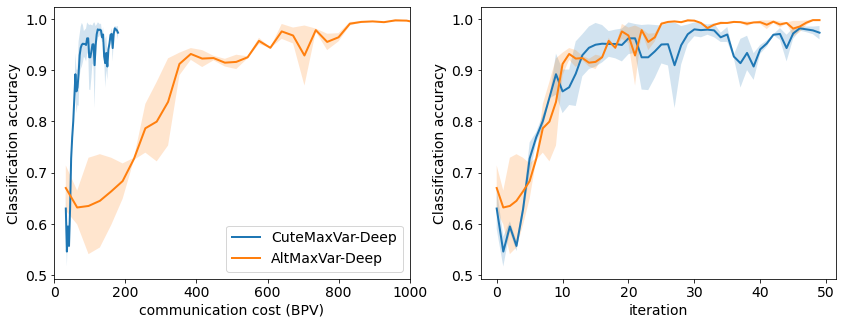

In [5]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

comm_cute = np.arange(50)*3 + 32
comm_alt = np.arange(50)*32 + 32

cute_mean = acc['cute'].mean(axis=0)
alt_mean = acc['alt'].mean(axis=0)
cute_std = acc['cute'].std(axis=0)
alt_std = acc['alt'].std(axis=0)


axes[0].plot(comm_cute, acc['cute'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_cute, cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[0].plot(comm_alt, acc['alt'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_alt, alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[0].legend(['CuteMaxVar-Deep', 'AltMaxVar-Deep'], fontsize=14)
axes[0].set_xlabel('communication cost (BPV)', fontsize=14)
axes[0].set_ylabel('Classification accuracy', fontsize=14)
axes[0].set_xlim(0, 1000)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)


axes[1].plot(acc['cute'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(cute_mean)), cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[1].plot(acc['alt'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(alt_mean)), alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[1].set_xlabel('iteration', fontsize=14)
axes[1].set_ylabel('Classification accuracy', fontsize=14)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)


## Compute representations and their clustering accuracies for the given models

In [8]:
from dgcca.utils.clustering import *

dgcca_vanilla = torch.load('trained_models/dgcca_toy_altmaxvar_test.model')
dgcca_dist = torch.load('trained_models/dgcca_toy_cutemaxvar_test.model')

test_views, classes = create_synthData(N=1000)
test_views = [view.to(device) for view in test_views]


acc_raw = []

for view in test_views:
    acc_raw.append(get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=view, test_classes=classes[0]))

out1 = dgcca_vanilla(test_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(test_views)
G_vanilla = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_dist(test_views)
G_dist = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G_vanilla = G_vanilla.detach().to('cpu')
vanilla_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_vanilla, test_classes=classes[0])

G_dist = G_dist.detach().to('cpu')
dist_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_dist, test_classes=classes[0])

target = [t.to('cpu').detach() for t in test_views]



## t-SNE plots of the representations

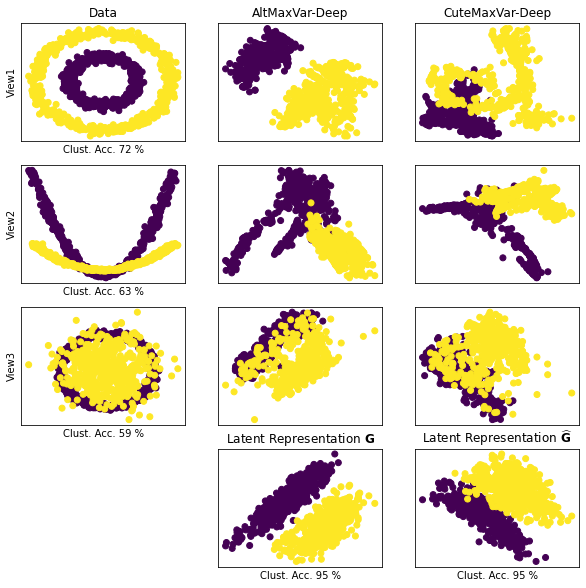

In [10]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[0,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[0]*100)) +" %")

axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[1,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[1]*100)) +" %")

axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[2,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[2]*100)) +" %")


axes[0,1].set_title("AltMaxVar-Deep")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].set_xlabel("Clust. Acc. " + str(int(vanilla_cluster_acc*100)) +" %")
axes[3,1].set_title('Latent Representation ' + r'${\mathbf{G}}$')
axes[3,1].scatter(G_vanilla[:,0], G_vanilla[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("CuteMaxVar-Deep")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].set_xlabel("Clust. Acc. " + str(int(dist_cluster_acc*100)) +" %")
axes[3,2].set_title('Latent Representation ' + r'$\widehat{\mathbf{G}}$')

axes[3,2].scatter(G_dist[:,0], G_dist[:,1], c=500*[1]+500*[2])

axes[3,0].axis('off')
for i in range(4):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
